# ESD_thermotrace


### Indicate the path to the input text file

In [13]:
input_file = 'input_highsierra/input_file.txt'

### Import libraries and input parameters

In [14]:
# import all libraries and functions
from ESD_thermotrace_functions import *

# display plots below the related cell
%matplotlib inline
# # Alternatively, open an interactive window for every figure
# %matplotlib notebook 

# set white background and large fontsize for all plots
sns.set(style='white', context='talk')

# read and parse input file
input_txt = read_input_file(input_file)

# get all parameters from parsed textfile
ipf, opf = input_txt[0][-1], input_txt[1][-1]
dem_filename = input_txt[2][-1]
e_map_filenames = input_txt[3][-1]
ws_filename = input_txt[4][-1]
bedrock_ages_filename = input_txt[5][-1]
detrital_ages_filenames = input_txt[6][-1]
res = input_txt[7][-1]
example_scenarios = input_txt[8][-1]
interp_method = input_txt[9][-1]
ext_rad = input_txt[10][-1]
age_map_filename = input_txt[11][-1]
age_map_u_filename = input_txt[12][-1]

print('THESE ARE YOUR INPUT PARAMETERS:\n')
for line in input_txt:
    print('{}: {}\n'.format(line[1],line[2]))

THESE ARE YOUR INPUT PARAMETERS:

input_folder: input_highsierra

output_folder: output_highsierra

dem_filename: dem84_30_clp.asc

erosion_map_filenames: []

watershed_outline_filename: inyo_ws.shp

bedrock_ages_filename: bd_highsierra.xlsx

detrital_ages_filenames: ['dd_inyo_fine.xlsx']

resolution: 90

example_scenarios: True

interpolation_method: rbf

extrapolation_radius: 2000

age_map_filename: None

age_map_uncertainty_filename: None



### Import data and display them

In [15]:
# Open DEM and read the metadata    
dem = DEM('topography')
dem.from_ascii(ipf+'/'+dem_filename)
dem.info()

# make dictionary of erosion maps
e_maps = {}
# fill the dictionary, if erosion maps are given
if len(e_map_filenames)>0:
    count=0
    for i in e_map_filenames:
        count+=1
        key = i[:i.find('.')]
        e_maps[key] = DEM(key)
        e_maps[key].from_ascii(i)
        e_maps[key].info()

# import interpolated age map and uncertainty, if given
if interp_method == 'imp':
    age_map = DEM('bedrock age')
    age_map.from_ascii(age_map_filename)
    age_map.info()
    age_map_u = DEM('bedrock age uncertainty')
    age_map_u.from_ascii(age_map_u_filename)
    age_map_u.info()
else:
    age_map, age_map_u = None, None


METADATA OF topography

xllcorner = -118.305972222165
yllcorner = 36.53652777782
ncols = 489
nrows = 262
cellsize [km] = 0.000277777778
cellsize [m] = ~30
min value = 1676.0
max value = 4401.0
NODATA_value = nan


/Users/andrea/Documents/docs/src/Python/ESD_thermotrace/ESD_thermotrace_public/ESD_thermotrace_functions.py:214: UserWarning: The column "zero_age_depth" contains Nans
 all zero age depths will be set to z-5000m
  warnings.warn('The column "zero_age_depth" contains Nans\n all zero age depths will be set to z-5000m')


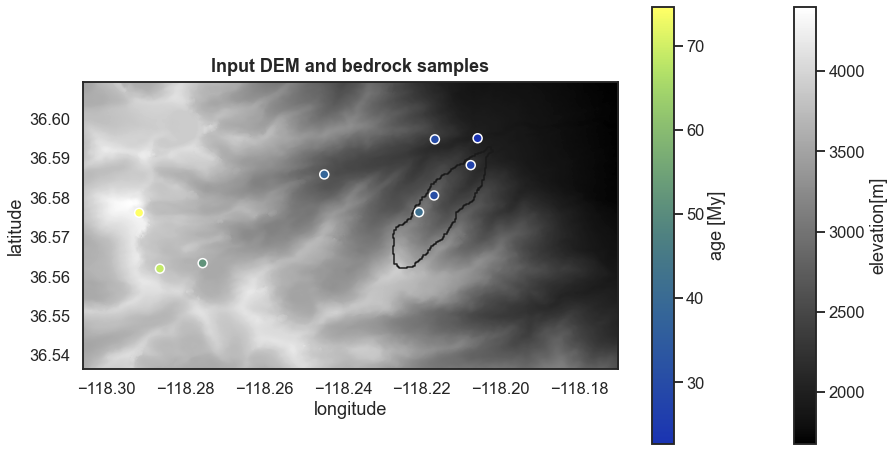

In [16]:
# import bedrock age dataset into a pandas.DataFrame
if interp_method != 'imp':
    bd, z, a, u, lat, lon, x_utm, y_utm, xx_utm, yy_utm, zz, aa = import_bedrock_data(ipf+'/'+bedrock_ages_filename)
else:
    bd = None # bedrock data not needed if age map is imported
    
ws_outline = gpd.read_file(ipf+'/'+ws_filename) # import watershed outline as geopandas.DataFrame 

if not path.exists(opf): # make output directory, if not existing yet
    mkdir(opf)

# assign all colormaps
dem_cmap, age_cmap, ero_cmap, err_cmap= scm6.grayC.reversed(), scm6.imola, scm6.vik, scm6.lajolla.reversed()

# plot dem and data points to check that everything worked fine    
plot_input_data(dem, e_maps, e_map_filenames, ws_outline, interp_method, bd, dem_cmap, age_cmap, ero_cmap,
                age_map, age_map_u, opf+'/input_data.pdf')

### Resample DEM and interpolate ages to resampled topographic surface

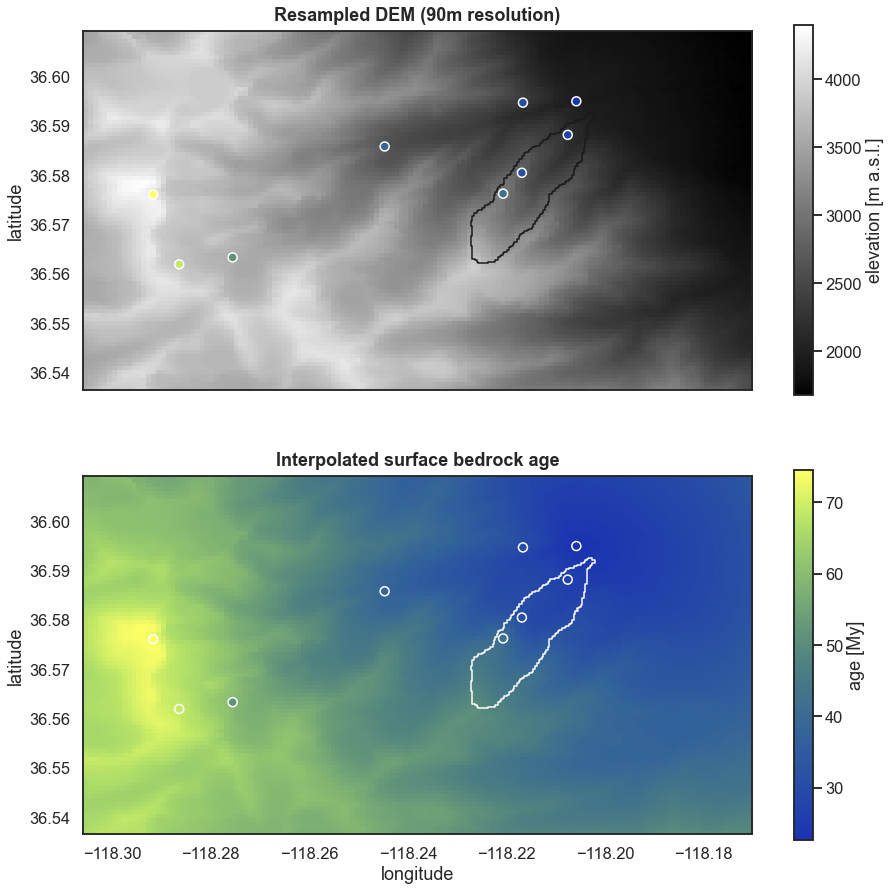

In [17]:
dem.resample(res)
if len(e_map_filenames)>0:
    for k,i in e_maps.items():
        i.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)

# Interpolate age data onto the topographic surface according to chosen method.
if interp_method =='imp':
    age_map.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84) # resample age map
    age_interp_map = age_map.zi_res

elif interp_method == 'rbf': # radial basis function
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(dem.xi_res, dem.yi_res, dem.zi_res)

elif interp_method == 'zln': # simple linear regression from age-elevation data
    reg0 = LinearRegression().fit(z.reshape(-1,1),a.reshape(-1,1))
    intercept0, coef0, R2 = reg0.intercept_, reg0.coef_, np.around(reg0.score(z.reshape(-1,1),a.reshape(-1,1)), 2)
    if R2 < 0.7:
        warnings.warn('\nLarge scatter of age-elevation data (R^2 = '+str(R2)+') \nYou might want to use a different interpolation method')
    age_interp_map = intercept0+coef0*dem.zi_res

else: # grid-data interpolation
    age_int = intr.griddata(np.concatenate(([xx_utm],[yy_utm],[zz])).transpose(), # known X
                            aa, # known Y
                            np.concatenate(([dem.xi_res_1d],[dem.yi_res_1d],[dem.zi_res_1d])).transpose()) # new X
    if interp_method == 'ext': # call extrapolation function if needed
        age_int = extrapolation(age_int,dem.xi_res_1d,dem.yi_res_1d,dem.zi_res_1d,a,x_utm,y_utm,z,ext_rad) 
    age_interp_map = age_int.reshape(dem.zi_res.shape) # reshape to 2D   
    
# Plot resampled DEM and interpolated age map
plot_resDEM_and_age_map(dem, res, age_interp_map, bd, ws_outline, interp_method, dem_cmap, age_cmap,
                        opf+'/DEMres'+str(res)+'_ageinterp.pdf')

### Make error map

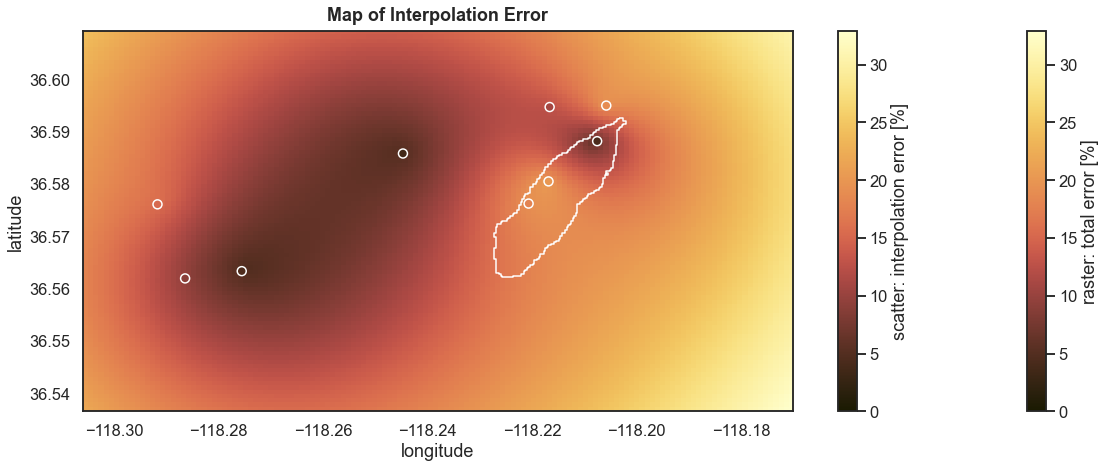

In [18]:
if interp_method != 'imp' and interp_method != 'zln':
    error_interp, age_interp_error_map = make_errormap(dem, res, z, a, u, aa, xx_utm, yy_utm, zz, x_utm, y_utm,
                                                      interp_method, ext_rad)

elif interp_method == 'zln':
    error_interp, age_interp_error_map = make_errormap_zln(dem, z, a, u)
    plot_linreg(R2, reg0, z, a, u, error_interp, opf+'/linear_regression.pdf') # Plot linear regr, if it applies

elif interp_method == 'imp':
    age_map_u.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84) # resample age error map
    age_interp_error_map = age_map_u.zi_res
    
# plot error map
plot_error_map(age_interp_error_map, error_interp, bd, ws_outline, interp_method, err_cmap, dem.extent84,
               opf+'/age_interp_error_map.pdf')

## Clip to watershed 

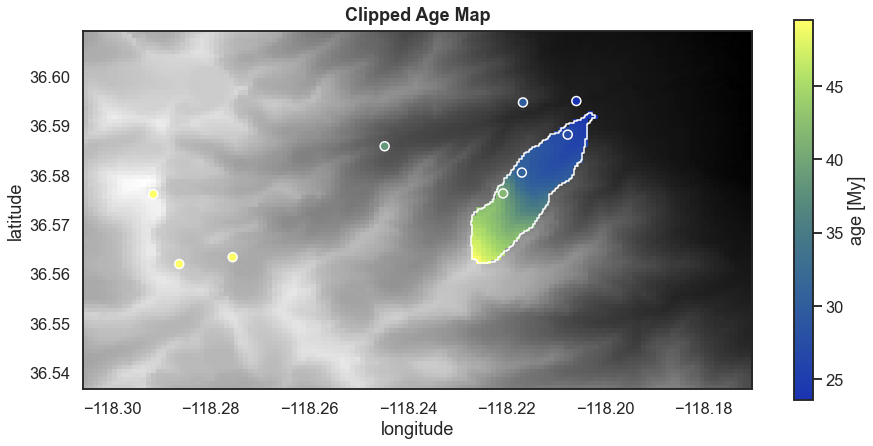

In [19]:
# clip all rasters to watershed
xi_res_clp = clip_to_ws(dem.xi_res, ws_filename, dem.extent84, ipf, opf)
yi_res_clp = clip_to_ws(dem.yi_res, ws_filename, dem.extent84, ipf, opf)
zi_res_clp = clip_to_ws(dem.zi_res, ws_filename, dem.extent84, ipf, opf)
if len(e_map_filenames)>0:
    e_maps_res_clp = dict()
    for k,i in e_maps.items():
        e_maps_res_clp[k] = clip_to_ws(i.zi_res, ws_filename, dem.extent84, ipf, opf)
        
age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, dem.extent84, ipf, opf)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, dem.extent84, ipf, opf)

# plot the clipped age map
plot_clipped_age_map(dem, age_interp_map_clp, ws_outline, bd, interp_method, dem_cmap, age_cmap,
                     opf+'/clipped_age_map.pdf')

## Make a table of x, y, elev, age, error, erosion

In [20]:
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary

# add labels and grids of the imported erosion maps
if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        labels.append(k)
        grids.append(i)

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    if g[g==g].size != zi_res_clp[zi_res_clp==zi_res_clp].size:
        warnings.warn('\nThe number of no-data cells in the '+l+' raster must match that of the clipped DEM\nPlease, make sure that the watershed polygon does not contain no-data.')         
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array

if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        ws_data[k] = ws_data[k]/ws_data[k].min() # minimum erosional weight should = 1

ws_data['Euni'] = np.ones(len(ws_data)) # make uniform erosion scenario
        
if example_scenarios:
    # Make default example erosional weights (exponential and inverse exponential function of elevation)
    ws_data['E_exp_Z'] = np.exp(ws_data.z/ws_data.z.min())
    ws_data.E_exp_Z = ws_data.E_exp_Z/ws_data.E_exp_Z.min()
    ws_data['E_inv_exp_Z'] = 1/ws_data.E_exp_Z
    ws_data.E_inv_exp_Z = ws_data.E_inv_exp_Z/ws_data.E_inv_exp_Z.min()
    
#     # increasing to the west
#     ws_data['E_exp_X'] = 1/np.exp(300*ws_data.x/ws_data.x.min())
#     ws_data.E_exp_X = ws_data.E_exp_X/ws_data.E_exp_X.min()

#     # Here you can play around with other erosional functions; first define one,
#     # then create the related column like this example:
#     def E_stepwise(z, z_steps, weights):
#         '''
#         example erosional function of z, where prescribed erosional weights are assigned for certain elevation ranges
#         z: elevation at which erosional weight is assigned
#         z_steps: list of elevation thresholds, ascending
#         weights: list of corresponding erosional weights
#         '''
#         if z>z_steps[-1]:
#             warnings.warn('also elevations above {} have been assigned {} \
#             as erosional weight'.format(z_steps[-1], weights[-1]))
#             return weights[-1]
#         else:
#             z_steps_a = np.array(z_steps)
#             return weights[z_steps.index(z_steps_a[z<z_steps_a][0])]

#     elevation_steps = [1000,1600,2300]
#     erosional_weights = [5,1,5]
#     ws_data['E_step'] = ws_data.z.apply(lambda z: E_stepwise(z,elevation_steps,erosional_weights))
#     ws_data.E_step = ws_data.E_step/ws_data.E_step.min()

# save to excel and show the first 5 rows of the table

ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)
ws_data.head()

,x,y,z,age,age_u%,Euni,E_exp_Z,E_inv_exp_Z
0,392455.296213,4.050373e+06,1975.0,23.582016,16.369769,1.0,1.000000,2.582766
1,392365.296213,4.050283e+06,2012.0,23.877858,14.981062,1.0,1.018911,2.534830
2,392455.296213,4.050283e+06,1997.0,23.881959,15.433244,1.0,1.011202,2.554155
3,392545.296213,4.050283e+06,1987.0,23.963191,15.868854,1.0,1.006094,2.567120
4,392185.296213,4.050193e+06,2082.0,24.592750,12.673394,1.0,1.055672,2.446561


## Make grain populations for all erosion scenarios and related distributions

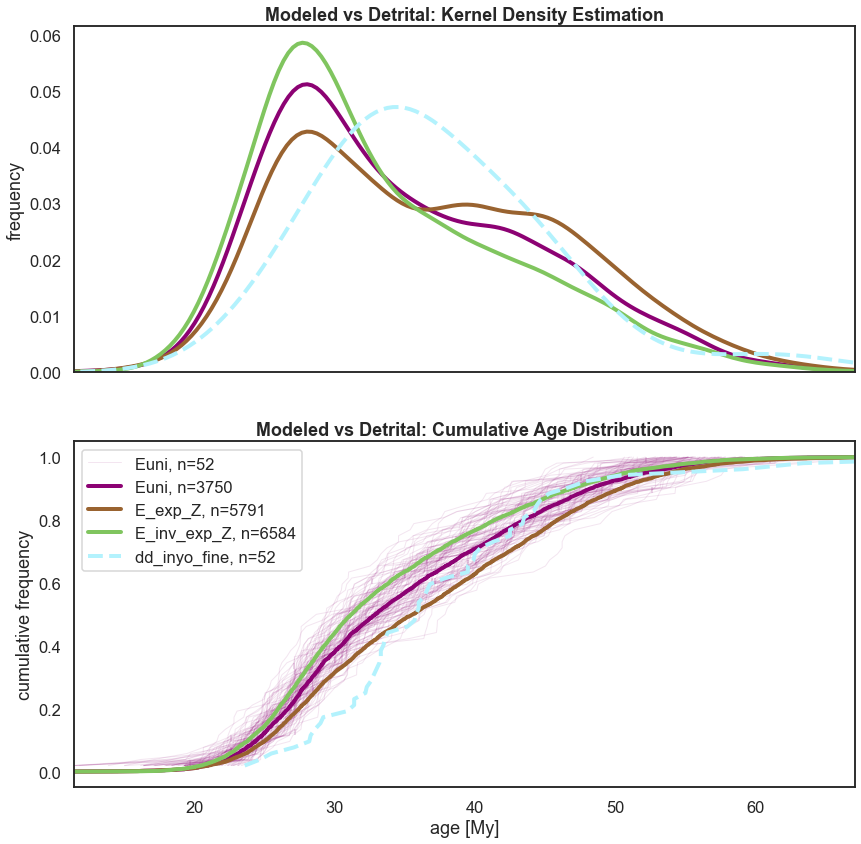

In [21]:
# import table of watershed data
ws_data = pd.read_excel(opf+'/xyz_age_eros.xlsx')

multiplier = 10 # starting number of grains for each cell (the more the better, but also slower...)
pops = OrderedDict() # preallocate dictionary of populations
scen_labels = list(ws_data.columns)[5:] # list of scenario labels to iterate through
for s in scen_labels:
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data['N_'+s] = np.rint(ws_data[s]*multiplier) # column that to informs how many grains (N) per cell
    # make a gaussian distribution for each cell
    # Draw from it N grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for A,U,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_'+s]):
        pops[s] = np.append(pops[s], np.random.normal(A,np.abs(A*U/100),int(N)))

########################################## DEFINE REFERENCE SCENARIO HERE ########################################
ref_scen = 'Euni' 
pops.move_to_end(ref_scen, last=False) # move ref_scen to first position in the dictionary

# also load the detrital data and make populations
dd, detr_labels = OrderedDict(), []
if type(detrital_ages_filenames) == str:
    detrital_ages_filenames = [detrital_ages_filenames]
for file in detrital_ages_filenames:
    detr_label = file[:file.find('.')]
    detr_labels.append(detr_label)
    dd[detr_label] = pd.read_excel(ipf+'/'+file)
    pops[detr_label] = dd[detr_label].age.values

# preallocate dictionary of distributions
dists = OrderedDict()
for label, pop in pops.items():
    dists[label] = make_cdf(pop)
    
######################################## SPECIFY N. OF DETRITAL GRAIN AGES HERE ##################################
num_grains = 52

# check if something detrital is there
if len(detrital_ages_filenames)<1:
    warnings.warn('\nYou have not specified any path to the detrital data.')

# Plot distributions
plot_distributions(pops, dists, ref_scen, detr_labels, opf+'/detrital_distributions.pdf', num_grains)

## Confidence in discerning between erosion scenarios and 'Euni'
## as a function of sample size.

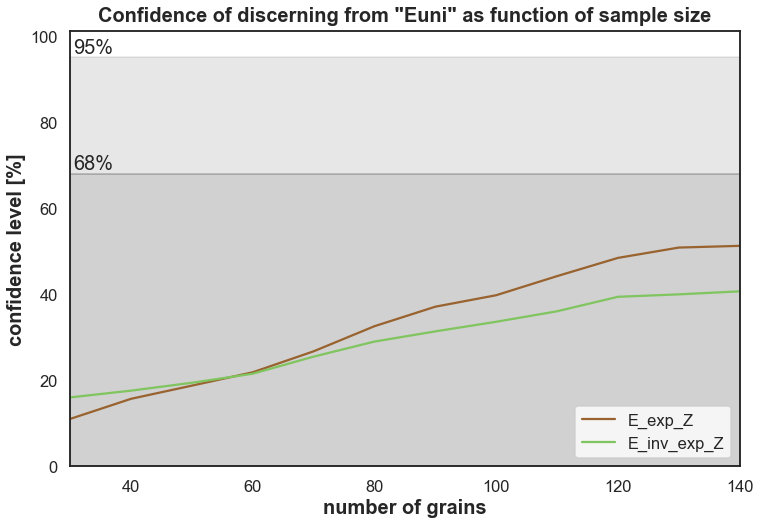

In [22]:
############################ DEFINE RANGE OF K VALUES AND N. OF ITERATIONS HERE ####################################
all_k = np.arange(30,150,10) # possible n. of dated grains (k) to consider
k_iter = 1000 # iterations per k value

# skip this if there is only one scenario
if len(scen_labels)>1:
    # calculate 95% confidence divergence for each k, between reference n=∞ and reference n=size of dd
    Dc_within, D_dist_dict, Dc = {}, {}, [] # prepare dictionaries and list to store results
    for k in all_k: # get array of random divergencies, using KS statistic
        D_arr = np.array([get_KS(np.random.choice(pops[ref_scen],k), dists[ref_scen]) for element in np.arange(k_iter)])
        D_arr.sort() # sort values
        D_arr_prob = (np.arange(D_arr.size)+1)/D_arr.size # calculate cumulative probability of each value
        ind95 = np.where(D_arr_prob<=0.95)[0][-1] # index of the 95th percentile
        Dc.append(D_arr[ind95]) # store values
        D_dist_dict[ref_scen+'_'+str(k)] = [D_arr, D_arr_prob]
    Dc_within[ref_scen] = Dc # list of critical distances, each for a k

    scen_labels1 = scen_labels.copy()
    scen_labels1.pop(scen_labels1.index(ref_scen)) # now remove ref_scen from labels for the next plot
    for scen in scen_labels1:
        for k in all_k: # get array of random divergences, using KS statistic
            D_arr = np.array([get_KS(np.random.choice(pops[scen],k), dists[ref_scen]) for i in np.arange(k_iter)])
            D_arr.sort() # sort values
            D_arr_prob = (np.arange(D_arr.size)+1)/D_arr.size # calculate cumulative probability of each value
            D_dist_dict[scen+'_'+str(k)] = [D_arr, D_arr_prob]

    # Calculate confidence as function of the number of grains
    # Compare Dc_within to scenarios for all k and get probability of scenarios being discerned from ref_scen
    probs = {}
    for scen in scen_labels1:
        probs1 = []
        for i in np.arange(len(all_k)): # for all k values
            # get index of element where distance scenario-ref_scen is greater than critical distance Dc_within
            ind = np.where(D_dist_dict[scen+'_'+str(all_k[i])][0]>Dc_within[ref_scen][i])[0][0]
            # get complementary probability at position ind (i.e. how many iterations are greater than that)
            probs1.append(100*(1-D_dist_dict[scen+'_'+str(all_k[i])][1][ind]))
        probs[scen] = probs1

    # Plot the confidence as function of grain number
    plot_confidence(prob_dict=probs, all_k=all_k, ref_scen=ref_scen,
                    saveas=opf+'/scenarios_confidence_sample_size.pdf',num_of_colors=len(dists))

## How do the different scenarios fit to the detrital data?

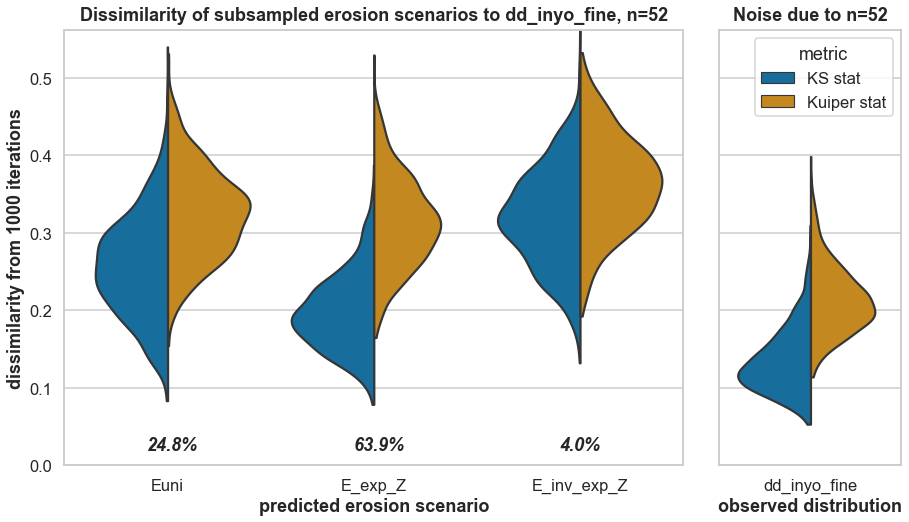

In [23]:
# check if something is there
if len(detrital_ages_filenames)<1:
    warnings.warn('\nYou have not specified any path to the detrital data.\nPlease check the input parameters.')

iterations = 1000 # number of iterations to run
 
# make a detrital population that takes analytical uncertainty into account and see how it compares to scenarios
pops1_sigma, scen2detr = make_pops_1sigma(dd, pops, dists, scen_labels, iterations)

# calculate percentages of overlap and 68%-95% confidence of KS statistic to observations
q68q95, overlaps = get_quantiles_and_overlaps(dd, scen2detr, pops, dists, scen_labels, iterations)
        
# plot all violins to visually compare  
for key,item in dd.items(): 
    plot_violins(scen2detr[key], key, 'divergence', opf+'/fit_to_'+key+'_data_violinplot.pdf',iterations,
                 len(item), overlaps)

## Multidimensional Scaling

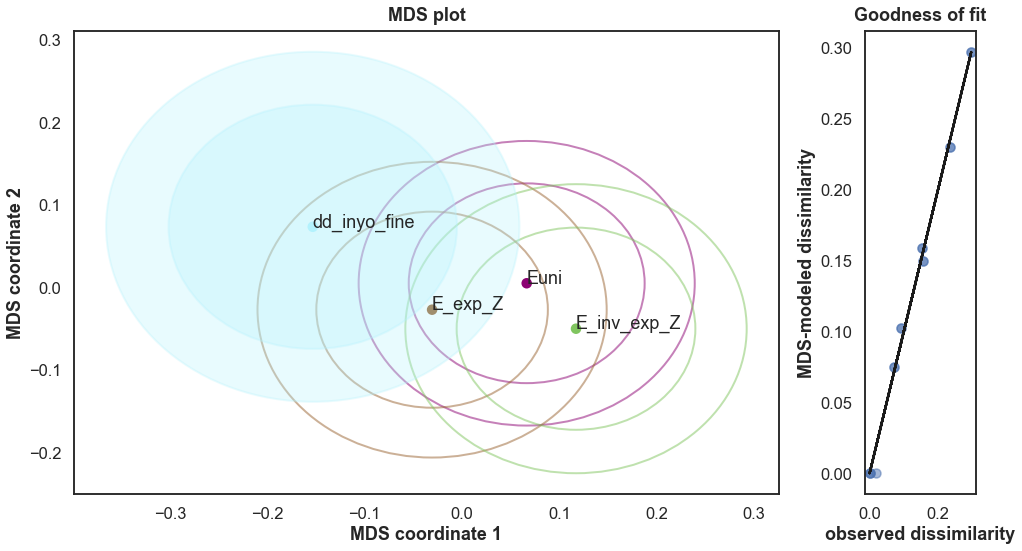

In [24]:
# prepare dissimilarity matrix based on KS statistics
l = list(pops.keys())
diss = np.zeros((len(l),len(l)))
for i in np.arange(len(l)):
    for j in np.arange(len(l)):
        diss[i,j] = get_KS(pops[l[i]], make_cdf(pops[l[j]]))
for i in np.arange(len(l)):
    for j in np.arange(len(l)):
        diss[j,i] = diss[i,j] # copy the other half of the matrix

# run metric MDS and fit to dissimilarity matrix
mmds = MDS(n_components=2, metric=True, dissimilarity='precomputed',eps=1e-3)
x = mmds.fit(diss)

# visualize dissimilarity among distributions, and related confidence intervals in a 2D map
plot_MDS_results(x, scm6.hawaii, pops, q68q95, scen_labels, opf+'/fit_to_'+key+'_MDS_plot.pdf')